# Predictive Analytics : Neural Networks
**Author: Onur Koc**

**Task:**

Develop two prediction models that predict taxi trip demand using a) support vector machines and b) neural networks (deep learning) in spatio-temporal resolution (i.e., spatial-unit and time buckets). In other words, your method should predict for each spatial unit (hexagon and census tract) and time-basket (e.g., 08am-11.59am) the taxi demand. Also adevise a reasonable validation strategy for your prediction model (i.e., definition of test, training data etc).

## Preamble

In [3]:
# importing required modules 
import numpy as np
import pandas as pd
import matplotlib as mpl
import h3
import h3pandas
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import holidays
import io
import urllib.request

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

from vincenty import vincenty 
from scipy import stats
from scipy.stats import randint as sp_randint
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow_addons.metrics import RSquare

%matplotlib inline

**Datasets**

**Summary of Multiindex Datasets:**

<ins>Spatio-Temporal Aggregations for Census Tracts:</ins>
+ taxi_by_census_tract_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_census_tract_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_census_tract_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_census_tract_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 6:</ins>
+ taxi_by_h3_6_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_6_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_6_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_6_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 7:</ins>
+ taxi_by_h3_7_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_7_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_7_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_7_24H &nbsp;&nbsp;: Daily Aggregation

**Summary of Features**

<ins>Target Variable:</ins> 
+ trip_demand : number of starting trips for each time bucket of year 2021

<ins>Features:</ins>

+ precip : binary feature that indicates whether the current time-bucket has precipitation or not.
+ windspeed_z : normalized average windspeed
+ temp_z : normalized average temperature
+ temp_z_ma_7d : moving average of the normalized temperature over 7 days
+ temp_z_std_7d : moving standard deviation of the normalized temperature over 7 days
+ weekday_sin : sine tranformed weekday
+ weekday_cos : cosine transformed weekday
+ is_weekend : binary feature to indicate whether the current time-bucket falls on a weekend or not
+ is_holiday : binary feature to indicate whether the current time-bucket falls on a holiday or not
+ 4 season dummies : season_Autumn, season_Spring, season_Summer & season_Winter

**Reading the Datasets**

In [4]:
file_path = "./data/datasets/"

taxi_by_h3_6_1H = pd.read_pickle(f"{file_path}taxi_by_h3_6_1H.pkl")
taxi_by_h3_6_2H = pd.read_pickle(f"{file_path}taxi_by_h3_6_2H.pkl")
taxi_by_h3_6_6H = pd.read_pickle(f"{file_path}taxi_by_h3_6_6H.pkl")
taxi_by_h3_6_24H = pd.read_pickle(f"{file_path}taxi_by_h3_6_24H.pkl")

taxi_by_h3_7_1H = pd.read_pickle(f"{file_path}taxi_by_h3_7_1H.pkl")
taxi_by_h3_7_2H = pd.read_pickle(f"{file_path}taxi_by_h3_7_2H.pkl")
taxi_by_h3_7_6H = pd.read_pickle(f"{file_path}taxi_by_h3_7_6H.pkl")
taxi_by_h3_7_24H = pd.read_pickle(f"{file_path}taxi_by_h3_7_24H.pkl")

taxi_by_census_tract_1H = pd.read_pickle(f"{file_path}taxi_by_census_tract_1H.pkl")
taxi_by_census_tract_2H = pd.read_pickle(f"{file_path}taxi_by_census_tract_2H.pkl")
taxi_by_census_tract_6H = pd.read_pickle(f"{file_path}taxi_by_census_tract_6H.pkl")
taxi_by_census_tract_24H = pd.read_pickle(f"{file_path}taxi_by_census_tract_24H.pkl")

## Evaluating First Simple NN Model

**Defining non zero evaluation metrics**

In [5]:
def non_zero_mape(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    absolute_percentage_errors = np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)
    non_zero_mape = np.mean(absolute_percentage_errors) * 100
    
    return non_zero_mape

def non_zero_mse(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    non_zero_mse = np.mean((y_true_non_zero - y_pred_non_zero)**2)
    
    return non_zero_mse

def non_zero_mae(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    non_zero_mae = np.mean(np.abs(y_true_non_zero - y_pred_non_zero))
    
    return non_zero_mae

**Defining a function to split the dataset into train-test**

In [6]:
def split_dataset(df, area_id):
    # Splitting the dataframe into feature columns and the prediction column
    X = df.loc[area_id].iloc[:, 1:]
    y = df.loc[area_id].iloc[:, 0]

    # Splitting the data into a 80-20 train-test split without shuffle since its time series data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

**Defining helper functions to build and evaluate the model for a given area id**

In [7]:
def build_model_simple(activation='relu', init_weights='he_uniform', optimizer='Adam'):
    model = models.Sequential()
    
    # Input Layer
    model.add(layers.Dense(64, activation=activation, kernel_initializer= init_weights, input_shape=(21,)))
    
    # Hidden Layer
    model.add(layers.Dense(32, activation=activation, kernel_initializer= init_weights))
    model.add(layers.Dense(16, activation=activation, kernel_initializer= init_weights))
    
    # Output Layer
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])
    return model

In [8]:
def model_eval(df, area_id, epochs, batch_size):
    # Train-Test split for a fixed area id
    X_train, X_test, y_train, y_test = split_dataset(df, area_id)

    # Build model and train
    model = build_model_simple()
    model_fit = model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs=epochs,batch_size=batch_size,verbose=0)

    # Plot Error
    plt.figure(figsize=(4, 2))  # Adjust the figure size as needed
    train_mae = model_fit.history['mae']
    train_mse = model_fit.history["mse"]
    test_mae = model_fit.history['val_mae']  # Validation MAE
    test_mse = model_fit.history['val_mse']  # Validation MSE
    epochs = range(1, len(train_mae) + 1)
    plt.plot(epochs, train_mae, 'b', label='Training MAE')
    plt.plot(epochs, np.sqrt(train_mse), 'r', label="Training RMSE")
    plt.plot(epochs, test_mae, 'g', label='Test MAE')
    plt.plot(epochs, np.sqrt(test_mse), 'm', label="Test RMSE")
    plt.title('Progress over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    # Plot Train Error
    y_train_pred = model.predict(X_train)
    print("TRAINING ERROR:")
    print("MAE ", mean_absolute_error(y_train,y_train_pred))
    print("RMSE ", np.sqrt(mean_squared_error(y_train,y_train_pred)))
    print("Non Zero MAE ", non_zero_mae(y_train,y_train_pred.flatten()))
    print("Non Zero RMSE ", np.sqrt(non_zero_mse(y_train,y_train_pred.flatten())))
    print("Non Zero MAPE ", non_zero_mape(y_train,y_train_pred.flatten()))
    #print("R2 ", r2_score(y_train,y_train_pred))
    print("\n")

    # Plot Test Error
    y_test_pred = model.predict(X_test)
    print("TEST ERROR:")
    print("MAE ",mean_absolute_error(y_test,y_test_pred))
    print("RMSE ", np.sqrt(mean_squared_error(y_test,y_test_pred)))
    print("Non Zero MAE ", non_zero_mae(y_test,y_test_pred.flatten()))
    print("Non Zero RMSE ", np.sqrt(non_zero_mse(y_test,y_test_pred.flatten())))
    print("Non Zero MAPE ", non_zero_mape(y_test,y_test_pred.flatten()))
    #print("R2 ",r2_score(y_test,y_test_pred))

**Evaluating the NN model for a fixed area id and different hyperparameters**

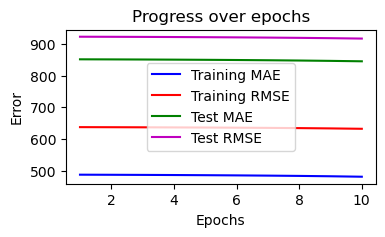

10/10 [==============================] - 0s 3ms/step
TRAINING ERROR:
MAE  479.93108262754464
RMSE  631.3380602336129
Non Zero MAE  479.93108262754464
Non Zero RMSE  631.3380602336129
Non Zero MAPE  94.89556516675603


3/3 [==============================] - 0s 2ms/step
TEST ERROR:
MAE  845.2909194214703
RMSE  917.0123388234238
Non Zero MAE  845.2909194214703
Non Zero RMSE  917.0123388234238
Non Zero MAPE  98.95105089310623


In [9]:
# Epochs:10 , Batch Size:64
model_eval(taxi_by_census_tract_24H, 17031980000.0, 10, 64)

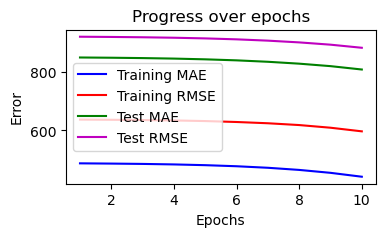

10/10 [==============================] - 0s 2ms/step
TRAINING ERROR:
MAE  430.6529030277304
RMSE  586.5953816391719
Non Zero MAE  430.6529030277304
Non Zero RMSE  586.5953816391719
Non Zero MAPE  73.04419703804929


3/3 [==============================] - 0s 4ms/step
TEST ERROR:
MAE  809.4344891326068
RMSE  884.1163761636345
Non Zero MAE  809.4344891326068
Non Zero RMSE  884.1163761636345
Non Zero MAPE  93.2990931090334


In [10]:
# Epochs:10 , Batch Size:32
model_eval(taxi_by_census_tract_24H, 17031980000.0, 10, 32)

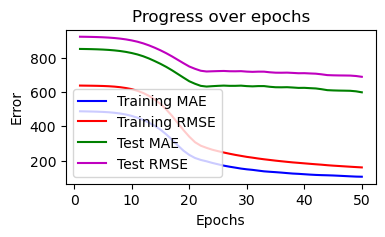

10/10 [==============================] - 0s 2ms/step
TRAINING ERROR:
MAE  105.51772208083166
RMSE  158.8505105654206
Non Zero MAE  105.51772208083166
Non Zero RMSE  158.8505105654206
Non Zero MAPE  34.92435664165821


3/3 [==============================] - 0s 2ms/step
TEST ERROR:
MAE  598.5901394151662
RMSE  689.0958056824913
Non Zero MAE  598.5901394151662
Non Zero RMSE  689.0958056824913
Non Zero MAPE  67.0571516266822


In [11]:
# Epochs:50 , Batch Size:32
model_eval(taxi_by_census_tract_24H, 17031980000.0, 50, 32)

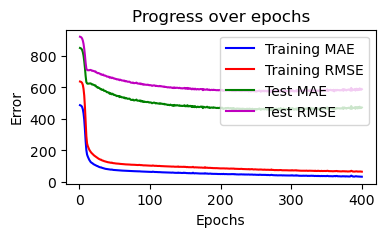

10/10 [==============================] - 0s 3ms/step
TRAINING ERROR:
MAE  32.488097602373934
RMSE  63.842010829916966
Non Zero MAE  32.488097602373934
Non Zero RMSE  63.842010829916966
Non Zero MAPE  7.925673433047523


3/3 [==============================] - 0s 3ms/step
TEST ERROR:
MAE  472.6303412032454
RMSE  588.9869972310911
Non Zero MAE  472.6303412032454
Non Zero RMSE  588.9869972310911
Non Zero MAPE  52.07881536912941


In [12]:
# Epochs:400 , Batch Size:16
model_eval(taxi_by_census_tract_24H, 17031980000.0, 400, 16)

**Conclusion: The simple NN model is not good enough to capture the underlying patterns of the data. It also might be due to the limitation from the current feature set.**

## Optimizing Hyperparameters with Randomized Search

+ **We are using time series CV split with 5 folds**
+ **Due to out computational resources, we optimze the hyperparameters in 2 stages**
+ **In the first stage we search for the optimal number of hidden layers, number of neurons in each hidden layer, number of epochs, batch size & activation function**
+ **In the second stage we search for the optimal initial weights & optimizer**

**Given our current computational capabilities, we have developed a method to approximate the best parameter set.**
**We know the top 5 demand areas for all spatial resolutions from the descriptive section:**

**Top 5 Resolution 6 Hexagon Ids:**
['862664c1fffffff',
 '862664cafffffff',
 '862759347ffffff',
 '862664c17ffffff',
 '862664d8fffffff']
 
**Top 5 Resolution 7 Hexagon Ids:**
['872664c1effffff',
 '872664c1affffff',
 '872664ca9ffffff',
 '872759343ffffff',
 '872664c16ffffff']
 
**Top 5 Census Tract Ids:** 
[17031980000.0, 17031839100.0, 17031320100.0, 17031081500.0, 17031281900.0]


**With this information, we use the top Ids for each spatial resolution as representatives to find the best hyperparameters for all Ids  so that there is a compromise.**

In [13]:
# When using Keras with scikit-learn's GridSearchCV or RandomizedSearchCV, you need to wrap your Keras model using KerasRegressor or KerasClassifier. 
# This is because scikit-learn expects an estimator object that follows its interface, which includes methods like fit() and predict().
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
import logging

# Set TensorFlow logging level to suppress warnings
tf.get_logger().setLevel(logging.ERROR)

#### Defining helper functions

**Defining helper functions to build an advanced model to do hyperparameter search**

In [70]:
def build_model_adv(n_hidden = 6, n_neurons = 32, activation='relu', init_weights='he_uniform', optimizer='Adam'):
    model = models.Sequential()
    
    # First Hidden Layer
    model.add(layers.Dense(64, activation=activation, kernel_initializer=init_weights, input_shape=(21,)))
    
    # Hidden Layer
    for layer in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation=activation))
    
    # Output Layer
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
    return model

**Defining a helper function to do RandomizedSearchCV for a given set of area ids and returning the CV results**

In [16]:
def hyperparameter_tuning_nn(spatialres, timeres, area_id, X_train, y_train, param_grid, n_iter, n_splits=5, random_state=42, n_jobs=8):
    # Load Keras Wrapper Model
    keras_reg = KerasRegressor(build_model_adv,
                               **param_grid,
                               verbose=0)

    # Number of time series CV splits
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Load randomized search 
    random_search = RandomizedSearchCV(keras_reg, 
                                       param_grid, 
                                       cv=tscv,
                                       n_iter=n_iter, 
                                       refit=True,
                                       n_jobs=n_jobs, 
                                       random_state=random_state,
                                       verbose=0)

    # Run randomized search 
    random_search.fit(X_train, y_train)

    # Get the best SVR model from the random search
    best_svr = random_search.best_estimator_
    
    # Get the best cross-validation test scores and parameters
    cv_results = random_search.cv_results_
    best_score = random_search.best_score_
    best_params = random_search.best_params_
    
    # Calculate training scores using cross-validation
    train_scores = cross_val_score(best_svr, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

    results = {
        'CV Mean MSE': -cv_results['mean_test_score'].mean(),
        'CV Std MSE': cv_results['std_test_score'].mean(), 
        'Mean Training Score': train_scores.min(),
        'Std Training Score': train_scores.std(),
        'CV Best Score': best_score,
        'Best Parameters': best_params,
        'CV Iter.': f"{n_iter}",
        'K Fold' : n_splits,
        'Spatial Res.': spatialres,
        'Time Res.': timeres,
        'Area Id': area_id
        }
    return results


def id_iterator(df, area_ids, spatialres, timeres, param_grid, n_iter):   
    # Define column names
    column_names = ['CV Mean MSE', 'CV Std MSE', 'Mean Training Score', 'Std Training Score', 'CV Best Score', 'Best Parameters', 'K Fold', 'CV Iter.', 'Spatial Res.', 'Time Res.', 'Area Id']

    # Initialize an empty DataFrame with column names
    results_df = pd.DataFrame(columns=column_names)
    
    for num in area_ids:
        # Train-Test split
        X_train, X_test, y_train, y_test = split_dataset(df, num)
        
        # Searching the best hyperparameter set (only on X_train and y_train for CV, we dont touch the test data)
        results = hyperparameter_tuning_nn(spatialres, timeres, num, X_train, y_train, param_grid, n_iter)

        # Convert the results dictionary into a DataFrame row
        results_row = pd.DataFrame([results], columns=results_df.columns)
        
        # Append the results to the DataFrame
        results_df = pd.concat([results_df, results_row], ignore_index=True)
        
    return results_df


**Testing the KerasRegressor Wrapper (Feeding the paramter grid in the wrapper)**

+ 'uniform': This method initializes weights with values drawn uniformly from a specified range, typically between -0.05 and 0.05. While simple, it may not always lead to the best convergence, especially in deeper networks.

+ 'normal': This method initializes weights with values drawn from a Gaussian distribution with a mean of 0 and a small variance. It can help to ensure that the activations don't explode or vanish as training progresses.

+ 'he_uniform': This method, also known as the He initialization, is designed for networks that use the ReLU (Rectified Linear Unit) activation function. It initializes weights using a uniform distribution scaled by a factor that depends on the number of input units. It can be effective for training deep networks with ReLU activations.

In [15]:
param_grid = {
    'n_hidden': [2, 3, 4, 5],
    'n_neurons': [16, 32, 64],
    'activation': ['tanh', 'relu', 'sigmoid'],
    'batch_size': [32,64,128],
    'epochs': [20,50,100],
    'init_weights': ['uniform', 'normal', 'he_uniform'],
    'optimizer' : ['SGD', 'RMSprop', 'Adam', 'Adamax'],
    "learning_rate": [5e-4 , 5e-3, 1e-2]
}

keras_reg = KerasRegressor(build_model_adv,
                           **param_grid,
                           verbose=0)
keras_reg

KerasRegressor(
	model=<function build_model_adv at 0x0000015712850820>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=['SGD', 'RMSprop', 'Adam', 'Adamax']
	loss=None
	metrics=None
	batch_size=[32, 64, 128]
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=[20, 50, 100]
	n_hidden=[2, 3, 4, 5]
	n_neurons=[16, 32, 64]
	activation=['tanh', 'relu', 'sigmoid']
	init_weights=['uniform', 'normal', 'he_uniform']
	learning_rate=[0.0005, 0.005, 0.01]
)

#### Hyperparameter Search First Stage: Searching for Hidden Layers, Neurons, Epochs, Batch Size & Activation Function

+ For the most part use the top 3 ids due to our current computational resources

**Defining the IDs and the Parameter Grid**

In [20]:
# Top 3 (5) Hexagon and Census tract Id's
top_5_h3_6 = ['862664c1fffffff', '862664cafffffff', '862759347ffffff']
top_5_h3_7 = ['872664c1effffff', '872664c1affffff', '872664ca9ffffff']
top_5_census = np.array([17031980000.0, 17031839100.0, 17031320100.0])

# First Stage Parameter Set (limited grid due to our current computational resources)
param_grid_1 = {
    'n_hidden': [4, 5, 6, 7],
    'n_neurons': [16, 32, 64],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

##### Census Tract Resolution

In [18]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_census_24h = id_iterator(taxi_by_census_tract_24H, top_5_census, 'Census', '24H', param_grid_1, 60)
results_census_24h

C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,3.703885,1.168945,-398312.939660,142720.741267,-2.452414,"{'n_neurons': 32, 'n_hidden': 6, 'epochs': 50,...",5,60,Census,24H,1.703198e+10
1,0.731269,0.614846,-137431.161539,49642.972733,-0.142806,"{'n_neurons': 32, 'n_hidden': 6, 'epochs': 50,...",5,60,Census,24H,1.703184e+10
2,2.677290,1.481097,-79112.043404,28836.273155,-1.488869,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 150...",5,60,Census,24H,1.703132e+10
3,2.986303,1.536319,-64209.628764,23864.580844,-2.006572,"{'n_neurons': 16, 'n_hidden': 7, 'epochs': 50,...",5,60,Census,24H,1.703108e+10
4,1.136761,0.961060,-33934.424165,10955.047542,-0.443815,"{'n_neurons': 32, 'n_hidden': 5, 'epochs': 100...",5,60,Census,24H,1.703128e+10


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_census_6h = id_iterator(taxi_by_census_tract_6H, top_5_census, 'Census', '6H', param_grid_1, 50)
results_census_6h 

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_census_2h = id_iterator(taxi_by_census_tract_2H, top_5_census, 'Census', '2H', param_grid_1, 50)
results_census_2h

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_census_1h = id_iterator(taxi_by_census_tract_1H, top_5_census, 'Census', '1H', param_grid_1, 50)
results_census_1h

##### Hexagon Resolution 7

In [22]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_7_24h = id_iterator(taxi_by_h3_7_24H , top_5_h3_7, 7, '24H', param_grid_1, 20)
results_7_24h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,6.335720,2.871291,-2.669227e+06,911083.686046,-2.713986,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,20,7,24H,872664c1effffff
1,3.631711,1.539542,-1.047369e+06,334651.671497,-1.947336,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,20,7,24H,872664c1affffff
2,3.034141,2.307866,-1.545224e+05,48806.587507,-0.778533,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,20,7,24H,872664ca9ffffff


In [23]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_7_6h = id_iterator(taxi_by_h3_7_6H , top_5_h3_7, 7, '6H', param_grid_1, 25)
results_7_6h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,0.363362,0.315260,-327524.166378,95332.607083,-0.126894,"{'n_neurons': 32, 'n_hidden': 7, 'epochs': 50,...",5,25,7,6H,872664c1effffff
1,0.279316,0.334806,-176742.811346,56904.793563,0.009713,"{'n_neurons': 32, 'n_hidden': 7, 'epochs': 50,...",5,25,7,6H,872664c1affffff
2,0.261060,0.382288,-27567.943345,5186.174055,0.055364,"{'n_neurons': 16, 'n_hidden': 7, 'epochs': 100...",5,25,7,6H,872664ca9ffffff


In [24]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_7_2h = id_iterator(taxi_by_h3_7_2H , top_5_h3_7, 7, '2H', param_grid_1, 25)
results_7_2h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,0.675185,0.507443,-76154.346810,24686.052283,-0.020717,"{'n_neurons': 16, 'n_hidden': 4, 'epochs': 50,...",5,25,7,2H,872664c1effffff
1,0.364829,0.341123,-35907.708868,12250.677730,-0.094933,"{'n_neurons': 16, 'n_hidden': 4, 'epochs': 50,...",5,25,7,2H,872664c1affffff
2,0.518292,0.490696,-5688.650493,1250.978661,0.029275,"{'n_neurons': 16, 'n_hidden': 6, 'epochs': 50,...",5,25,7,2H,872664ca9ffffff


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_7_1h = id_iterator(taxi_by_h3_7_1H , top_5_h3_7, 7, '1H', param_grid_1, 15)
results_7_1h

##### Hexagon Resolution 6

In [19]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_6_24h = id_iterator(taxi_by_h3_6_24H , top_5_h3_6, 6, '24H', param_grid_1, 50)
results_6_24h

C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,6.009426,2.586717,-6.374104e+06,1.817608e+06,-2.939343,"{'n_neurons': 32, 'n_hidden': 6, 'epochs': 100...",5,50,6,24H,862664c1fffffff
1,4.111495,2.658804,-3.002298e+05,7.922417e+04,-1.364588,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,50,6,24H,862664cafffffff
2,4.866480,2.031387,-6.466922e+05,1.683974e+05,-2.401884,"{'n_neurons': 32, 'n_hidden': 6, 'epochs': 100...",5,50,6,24H,862759347ffffff
3,4.614486,4.144075,-8.258979e+04,2.362786e+04,-2.119309,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,50,6,24H,862664c17ffffff
4,6.235495,4.607771,-7.368500e+04,2.203740e+04,-1.267624,"{'n_neurons': 64, 'n_hidden': 5, 'epochs': 50,...",5,50,6,24H,862664d8fffffff


In [21]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_6_6h = id_iterator(taxi_by_h3_6_6H , top_5_h3_6, 6, '6H', param_grid_1, 15)
results_6_6h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,0.617428,0.681188,-1.460982e+06,471274.741664,-0.095855,"{'n_neurons': 16, 'n_hidden': 7, 'epochs': 50,...",5,15,6,6H,862664c1fffffff
1,0.324700,0.470656,-3.747660e+04,6520.214292,0.040060,"{'n_neurons': 32, 'n_hidden': 5, 'epochs': 100...",5,15,6,6H,862664cafffffff
2,0.608333,0.346363,-2.124010e+05,67787.263559,-0.369896,"{'n_neurons': 64, 'n_hidden': 6, 'epochs': 100...",5,15,6,6H,862759347ffffff


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_6_2h = id_iterator(taxi_by_h3_6_2H , top_5_h3_6, 6, '2H', param_grid_1, 15)
results_6_2h

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results_6_1h = id_iterator(taxi_by_h3_6_1H , top_5_h3_6, 6, '1H', param_grid_1, 15)
results_6_1h

**First Stage Selection:**
+ **Number of Hidden Layers: (1 +) 6**
+ **Number of Neurons in each Hidden Layer: 64 in the first , 32 after**
+ **Activation Function: ReLu**
+ **Batch Size: 16**
+ **Epochs: 50**

**On the basis of these two hyperparameters we are looking for the optimal inital weights and optimizer using again Random Search.**

#### Hyperparameter Search Second Stage: Searching for Initial Weights & Optimizer

+ For the most part use the top 3 ids due to our current computational resources

**Defining the IDs and the Parameter Grid**

In [72]:
# Top 5 Hexagon and Census tract Id's
top_5_h3_6 = ['862664c1fffffff', '862664cafffffff', '862759347ffffff']
top_5_h3_7 = ['872664c1effffff', '872664c1affffff', '872664ca9ffffff']
top_5_census = np.array([17031980000.0, 17031839100.0, 17031320100.0])


param_grid_2 = {
    'init_weights': ['uniform', 'normal', 'he_uniform'],
    'optimizer' : ['SGD', 'RMSprop', 'Adam', 'Adamax'],
}

##### Census Tract Resolution

In [73]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_census_24h = id_iterator(taxi_by_census_tract_24H, top_5_census, 'Census', '24H', param_grid_2, 10)
results2_census_24h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,13.122070,5.735057,-1.143836e+06,438640.511360,-13.117437,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,Census,24H,1.703198e+10
1,4.321889,1.363710,-3.596898e+05,125650.466858,-4.318619,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,Census,24H,1.703184e+10
2,12.590258,7.022096,-4.452278e+05,158107.317434,-12.580216,"{'optimizer': 'Adamax', 'init_weights': 'he_un...",5,10,Census,24H,1.703132e+10


In [74]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_census_6h = id_iterator(taxi_by_census_tract_6H, top_5_census, 'Census', '6H', param_grid_2, 10)
results2_census_6h 

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,1.870767,0.415422,-95632.764055,36783.320514,-1.821671,"{'optimizer': 'RMSprop', 'init_weights': 'he_u...",5,10,Census,6H,1.703198e+10
1,0.863509,0.160644,-36209.198098,12640.144543,-0.839424,"{'optimizer': 'Adamax', 'init_weights': 'he_un...",5,10,Census,6H,1.703184e+10
2,1.506717,0.382464,-39145.888855,13804.951281,-1.467032,"{'optimizer': 'SGD', 'init_weights': 'he_unifo...",5,10,Census,6H,1.703132e+10


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_census_2h = id_iterator(taxi_by_census_tract_2H, top_5_census, 'Census', '2H', param_grid_2, 10)
results2_census_2h

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_census_1h = id_iterator(taxi_by_census_tract_1H, top_5_census, 'Census', '1H', param_grid_2, 10)
results2_census_1h

##### Hexagon Resolution 7

In [213]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_7_24h = id_iterator(taxi_by_h3_7_24H , top_5_h3_7, 7, '24H', param_grid_2, 10)
results2_7_24h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,28.307386,10.308346,-1.378012e+07,4.562782e+06,-28.304720,"{'optimizer': 'RMSprop', 'init_weights': 'he_u...",5,10,6,24H,872664c1effffff
1,16.708029,7.160980,-5.252069e+06,1.742951e+06,-16.699746,"{'optimizer': 'Adamax', 'init_weights': 'he_un...",5,10,6,24H,872664c1affffff
2,16.673965,2.217050,-1.459140e+06,3.885048e+05,-16.666384,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,6,24H,872664ca9ffffff
3,23.967566,9.003394,-4.651648e+06,1.684366e+06,-23.960902,"{'optimizer': 'RMSprop', 'init_weights': 'he_u...",5,10,6,24H,872759343ffffff
4,18.602171,4.940702,-3.001721e+05,8.323130e+04,-18.583259,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,6,24H,872664c16ffffff


In [77]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_7_6h = id_iterator(taxi_by_h3_7_6H , top_5_h3_7, 7, '6H', param_grid_2, 10)
results2_7_6h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,2.649674,0.568687,-1.077224e+06,354036.403605,-2.627698,"{'optimizer': 'SGD', 'init_weights': 'he_unifo...",5,10,7,6H,872664c1effffff
1,1.927915,0.261979,-4.497066e+05,149264.372327,-1.909907,"{'optimizer': 'RMSprop', 'init_weights': 'he_u...",5,10,7,6H,872664c1affffff
2,2.275187,0.231775,-1.192872e+05,31430.793947,-2.252176,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,7,6H,872664ca9ffffff


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_7_2h = id_iterator(taxi_by_h3_7_2H , top_5_h3_7, 7, '2H', param_grid_2, 10)
results2_7_2h

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_7_1h = id_iterator(taxi_by_h3_7_1H , top_5_h3_7, 7, '1H', param_grid_2, 10)
results2_7_1h

##### Hexagon Resolution 6

In [75]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_6_24h = id_iterator(taxi_by_h3_6_24H , top_5_h3_6, 6, '24H', param_grid_2, 10)
results2_6_24h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,26.702840,11.607786,-4.299417e+07,1.411931e+07,-26.700207,"{'optimizer': 'SGD', 'init_weights': 'he_unifo...",5,10,6,24H,862664c1fffffff
1,22.842685,4.011930,-2.031593e+06,5.386251e+05,-22.836390,"{'optimizer': 'SGD', 'init_weights': 'he_unifo...",5,10,6,24H,862664cafffffff
2,23.967816,9.003906,-4.649082e+06,1.684050e+06,-23.961952,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,6,24H,862759347ffffff


In [76]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_6_6h = id_iterator(taxi_by_h3_6_6H , top_5_h3_6, 6, '6H', param_grid_2, 10)
results2_6_6h

,CV Mean MSE,CV Std MSE,Mean Training Score,Std Training Score,CV Best Score,Best Parameters,K Fold,CV Iter.,Spatial Res.,Time Res.,Area Id
0,2.398226,0.393401,-3.530836e+06,1.152957e+06,-2.387929,"{'optimizer': 'SGD', 'init_weights': 'he_unifo...",5,10,6,6H,862664c1fffffff
1,2.637863,0.322309,-1.595456e+05,4.167465e+04,-2.607416,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,6,6H,862664cafffffff
2,2.757587,0.628875,-3.743445e+05,1.329857e+05,-2.737144,"{'optimizer': 'Adam', 'init_weights': 'he_unif...",5,10,6,6H,862759347ffffff


In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_6_2h = id_iterator(taxi_by_h3_6_2H , top_5_h3_6, 6, '2H', param_grid_2, 10)
results2_6_2h

In [ ]:
# Iterate over the Ids and search for the best hyperparameters over the predefined parameter grid
results2_6_1h = id_iterator(taxi_by_h3_6_1H , top_5_h3_6, 6, '1H', param_grid_2, 10)
results2_6_1h

In [195]:
results_df["Best Parameters"][0]

{'optimizer': 'Adam', 'init_weights': 'he_uniform'}

**Second Stage Selection:**

+ **inital weights: he-uniform**
+ **Optimizer: Adam**

**On the basis of this optimal hyperparameter set we are evaluating all area id's.**

## Building & Evaluating Advanced NN Model

**Best Hyperparameter Set:**
+ **Number of Hidden Layers: (1 +) 6**
+ **Number of Neurons in each Hidden Layer: 64 in the first , 32 after**
+ **Activation Function: ReLu**
+ **Batch Size: 16**
+ **Epochs: 50**
+ **Initial Weights: he uniform**
+ **Optimizer: Adam**

#### Defining helper functions

**Defining helper functions to iterate over a given area id matrix for evaluation and using the predictor with the best parameter set**

In [78]:
def evaluate_id(best_model ,spatialres, timeres, area_id, X_test, y_test):
    # Evaluate the best NN model on the test set
    y_test_pred = best_model.predict(X_test)
    test_mse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_true = y_test, y_pred = y_test_pred)
    nz_mape = non_zero_mape(y_test, y_test_pred.flatten())
    nz_mse = np.sqrt(non_zero_mse(y_test, y_test_pred.flatten()))
    nz_mae = non_zero_mae(y_test, y_test_pred.flatten())
    
    # Save the resulting metrics
    results = {
        'RMSE': test_mse,
        'MAE': test_mae,
        'Non Zero RMSE': nz_mse,
        'Non Zero MAE': nz_mae,
        'Non Zero MAPE': nz_mape,
        'R-squared': r2,
        'Spatial Res.' : spatialres,
        'Time Res.' : timeres,
        'Id': area_id
    }
    return results


def id_eval_iterator(best_params, spatialres, timeres, area_ids, df):
    # Define column names
    column_names = ['RMSE', 'MAE', 'R-squared', 'Non Zero RMSE', 'Non Zero MAE', 'Non Zero MAPE', 'Spatial Res.', 'Time Res.', 'Id']

    # Initialize an empty DataFrame with column names
    results_df = pd.DataFrame(columns=column_names)
    
    # Iterating over all area id's -> fit and evaluate all area id's
    for num in area_ids:
        # Train-Test split
        X_train, X_test, y_train, y_test = split_dataset(df, num)
        
        # Build a NN model with the best parameters
        best_model = build_model_adv(n_hidden= best_params['n_hidden'], 
                                     n_neurons= best_params['n_neurons'], 
                                     activation= best_params['activation'], 
                                     init_weights= best_params['init_weights'], 
                                     optimizer= best_params['optimizer'])
        
        # Fit the NN model to the dataset corresponding to the area id 'num' -> , maybe also validation_data=(X_test, y_test) for training error
        best_model.fit(X_train,
                       y_train, 
                       epochs= best_params['epochs'],
                       batch_size= best_params['batch_size'],
                       verbose=0)

        # Train and Evaluate the Dataset for a fixed Area id
        results = evaluate_id(best_model ,spatialres, timeres, num, X_test, y_test)
        
        # Convert the results dictionary into a DataFrame row
        results_row = pd.DataFrame([results], columns=results_df.columns)
        
        # Append the results to the DataFrame
        results_df = pd.concat([results_df, results_row], ignore_index=True)
        
    return results_df

#### Best Parameter Model Evaluation

**Getting all area id's of all spatio-temporal resolutions**

In [79]:
# Hexagon resolution 6 Id's 
h3_6_1H_ids = taxi_by_h3_6_1H.index.get_level_values('h3_6_pickup').unique()
h3_6_2H_ids = taxi_by_h3_6_2H.index.get_level_values('h3_6_pickup').unique()
h3_6_6H_ids = taxi_by_h3_6_6H.index.get_level_values('h3_6_pickup').unique()
h3_6_24H_ids = taxi_by_h3_6_24H.index.get_level_values('h3_6_pickup').unique()

# Hexagon resolution 7 Id's 
h3_7_1H_ids = taxi_by_h3_7_1H.index.get_level_values('h3_7_pickup').unique()
h3_7_2H_ids = taxi_by_h3_7_2H.index.get_level_values('h3_7_pickup').unique()
h3_7_6H_ids = taxi_by_h3_7_6H.index.get_level_values('h3_7_pickup').unique()
h3_7_24H_ids = taxi_by_h3_7_24H.index.get_level_values('h3_7_pickup').unique()

# Census tract Id's 
census_tract_1H_ids = taxi_by_census_tract_1H.index.get_level_values('pickup_census_tract').unique()
census_tract_2H_ids = taxi_by_census_tract_2H.index.get_level_values('pickup_census_tract').unique()
census_tract_6H_ids = taxi_by_census_tract_6H.index.get_level_values('pickup_census_tract').unique()
census_tract_24H_ids = taxi_by_census_tract_24H.index.get_level_values('pickup_census_tract').unique()

**Iterating over all area IDs for each spatio-temporal resolution and evaluating the predictive perfomance for each ID**

In [80]:
# Best parameter set
best_params = {
    'n_hidden': 6,
    'n_neurons': 32,
    'activation': 'relu',
    'batch_size': 16,
    'epochs': 50,
    'init_weights': 'he_uniform',
    'optimizer' : 'Adam',
}

##### Census Tract Resolution

In [91]:
# Iterate over the Ids in the dataset and evaluate the best NN model
eval_census_24H = id_eval_iterator(best_params, 'Census', '24H', census_tract_24H_ids, taxi_by_census_tract_24H)

3/3 [==============================] - 0s 3ms/step


In [92]:
eval_census_24H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE,Id
count,483.000000,483.000000,483.000000,321.000000,321.000000,321.000000,4.830000e+02
mean,9.360541,7.531003,-0.328715,15.535727,12.992705,95.494076,1.703138e+10
std,52.866332,44.320653,1.953507,64.149622,53.737834,9.115818,2.997544e+05
min,0.000623,0.000470,-40.411600,0.595197,0.595197,56.603521,1.703101e+10
25%,0.028531,0.010077,-0.135251,1.378146,1.272267,95.421595,1.703108e+10
50%,0.234193,0.043414,-0.018007,2.001368,1.993113,99.778824,1.703132e+10
75%,0.568774,0.146475,0.000000,3.001503,2.987611,100.060785,1.703169e+10
max,661.761638,560.870531,0.155357,661.761638,560.870531,114.912461,1.703198e+10


In [93]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_census_6H = id_eval_iterator(best_params, 'Census', '6H', census_tract_6H_ids, taxi_by_census_tract_6H)

10/10 [==============================] - 0s 2ms/step


In [94]:
eval_census_6H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE,Id
count,483.000000,483.000000,483.000000,321.000000,321.000000,321.000000,4.830000e+02
mean,3.588716,2.408415,-0.136118,7.479077,5.871905,101.024262,1.703138e+10
std,19.768947,14.322004,0.797528,25.034395,18.653024,23.708119,2.997544e+05
min,0.000078,0.000047,-15.119733,0.923187,0.923187,58.103047,1.703101e+10
25%,0.013648,0.004842,-0.052561,1.375741,1.285454,98.879158,1.703108e+10
50%,0.117094,0.013027,-0.005531,2.000012,1.991703,99.929694,1.703132e+10
75%,0.280428,0.044259,0.000000,2.993747,2.679863,100.045624,1.703169e+10
max,229.804939,172.290981,0.157419,229.804939,172.290981,444.321044,1.703198e+10


In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_census_2H = id_eval_iterator(best_params, 'Census', '2H', census_tract_2H_ids, taxi_by_census_tract_2H)
eval_census_2H.describe()

In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_census_1H = id_eval_iterator(best_params, 'Census', '1H', census_tract_1H_ids, taxi_by_census_tract_1H)
eval_census_1H.describe()

##### Hexagon Resolution 7

In [85]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_7_24H = id_eval_iterator(best_params, 7, '24H', h3_7_24H_ids, taxi_by_h3_7_24H)

3/3 [==============================] - 0s 4ms/step


In [86]:
eval_7_24H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,105.632601,91.367471,-1.705832,105.634308,91.369824,40.560677
std,342.780057,302.540561,1.434465,342.779537,302.539856,17.160398
min,2.376243,1.848094,-5.969753,2.350786,1.847365,20.112018
25%,5.999987,4.731936,-2.585178,5.999987,4.731936,29.383206
50%,11.536244,9.083033,-1.496709,11.536244,9.083033,33.311700
75%,27.907671,23.142107,-0.500372,27.907671,23.142107,45.848874
max,2067.070162,1861.605475,0.208822,2067.070162,1861.605475,113.341600


In [87]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_7_6H = id_eval_iterator(best_params, 7, '6H', h3_7_6H_ids, taxi_by_h3_7_6H)

10/10 [==============================] - 0s 2ms/step


In [88]:
eval_7_6H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,42.423806,32.993018,-0.556266,42.557171,33.117343,84.439572
std,126.028980,100.098597,0.256931,125.989782,100.062288,23.985014
min,1.081108,0.689378,-1.339881,1.555786,1.123386,52.485716
25%,3.679857,2.702088,-0.722180,3.765800,2.732185,70.166117
50%,6.233436,4.745098,-0.523769,6.305249,4.810190,76.634988
75%,16.380822,13.094521,-0.380551,16.396049,13.189500,93.451887
max,771.745638,630.104639,-0.083949,771.745638,630.104639,191.024897


In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_7_2H = id_eval_iterator(best_params, 7, '2H', h3_7_2H_ids, taxi_by_h3_7_2H)

In [ ]:
eval_7_2H.describe()

In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_7_1H = id_eval_iterator(best_params, 7, '1H', h3_7_1H_ids, taxi_by_h3_7_1H)

In [ ]:
eval_7_1H.describe()

##### Hexagon Resolution 6

In [81]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_6_24H = id_eval_iterator(best_params, 6, '24H', h3_6_24H_ids, taxi_by_h3_6_24H)

3/3 [==============================] - 0s 3ms/step


In [82]:
eval_6_24H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,297.801082,261.460409,-2.294374,297.812087,261.473916,35.691502
std,813.115475,716.788188,1.434607,813.111316,716.783100,12.275812
min,2.686283,2.094890,-5.710700,2.961426,2.432550,16.345503
25%,15.649600,12.520517,-2.999734,15.649600,12.520517,30.095392
50%,32.551695,26.760296,-2.169189,32.551695,26.760296,33.286637
75%,155.309904,138.312307,-1.324090,155.309904,138.312307,39.945449
max,3968.774130,3505.519744,0.193478,3968.774130,3505.519744,72.937724


In [83]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_6_6H = id_eval_iterator(best_params, 6, '6H', h3_6_6H_ids, taxi_by_h3_6_6H)

10/10 [==============================] - 0s 2ms/step


In [84]:
eval_6_6H.describe()

,RMSE,MAE,R-squared,Non Zero RMSE,Non Zero MAE,Non Zero MAPE
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,120.641157,95.852042,-0.646962,120.711843,95.924984,87.270397
std,308.726453,246.432509,0.241750,308.698926,246.404011,22.618943
min,1.156066,0.742415,-1.245094,1.863316,1.600410,56.254785
25%,7.140286,5.726880,-0.808309,7.193429,5.760424,72.789631
50%,18.480244,14.398300,-0.640755,18.480244,14.398300,84.195341
75%,83.356822,65.393716,-0.469156,83.356822,65.393716,91.720231
max,1518.535059,1214.068583,-0.279352,1518.535059,1214.068583,162.841317


In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_6_2H = id_eval_iterator(best_params, 6, '2H', h3_6_2H_ids, taxi_by_h3_6_2H)

In [ ]:
eval_6_2H.describe()

In [ ]:
# Iterate over the Ids in the dataset and evaluate the best SVR model
eval_6_1H = id_eval_iterator(best_params, 6, '1H', h3_6_1H_ids, taxi_by_h3_6_1H)

In [ ]:
eval_6_1H.describe()

**Summary:**
+ 

#### Saving the Evaluation Results for Comparison

In [96]:
#summary_nn_census_24H = eval_census_24H.describe()
#summary_nn_census_6H = eval_census_6H.describe()
#summary_nn_census_2H = eval_census_2H.describe()
#summary_nn_census_1H = eval_census_1H.describe()
#summary_nn_7_24H = eval_7_24H.describe()
#summary_nn_7_6H = eval_7_6H.describe()
#summary_nn_7_2H = eval_7_2H.describe()
#summary_nn_7_1H = eval_7_1H.describe()
#summary_nn_6_24H = eval_6_24H.describe()
#summary_nn_6_6H = eval_6_6H.describe()
#summary_nn_6_2H = eval_6_2H.describe()
#summary_nn_6_1H = eval_6_1H.describe()

file_path = "./data/datasets/"
#summary_nn_census_24H.to_pickle(f"{file_path}summary_nn_census_24H.pkl")
#summary_nn_census_6H.to_pickle(f"{file_path}summary_nn_census_6H.pkl")
#summary_nn_census_2H.to_pickle(f"{file_path}summary_nn_census_2H.pkl")
#summary_nn_census_1H.to_pickle(f"{file_path}summary_nn_census_1H.pkl")
#summary_nn_census_24H.to_pickle(f"{file_path}summary_nn_census_24H.pkl")
#summary_nn_census_6H.to_pickle(f"{file_path}summary_nn_census_6H.pkl")
#summary_nn_7_2H.to_pickle(f"{file_path}summary_nn_7_2H.pkl")
#summary_nn_7_1H.to_pickle(f"{file_path}summary_nn_7_1H.pkl")
#summary_nn_6_24H.to_pickle(f"{file_path}summary_nn_6_24H.pkl")
#summary_nn_6_6H.to_pickle(f"{file_path}summary_nn_6_6H.pkl")
#summary_nn_6_2H.to_pickle(f"{file_path}summary_nn_6_2H.pkl")
#summary_nn_6_1H.to_pickle(f"{file_path}summary_nn_6_1H.pkl")

## Outlook

+ How good is your model? Evaluate your model’s performance and comment on its shortfalls.
+ With this realization, do you think it is worth to employ a deep-learning approach?
+ How could the model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project

**Shortfalls & Improvements:**  In addition to SVM

+ By implementing a three-stage hyperparameter search, including an additional regularization stage, we can enhance the model's performance. In the third stage, our focus is on improving generalizability through the incorporation of regularization techniques, such as dropout layers, early stopping, and learning rate optimization.
+ Due to out current computational resources, we are only able to compute the best hyperparameters for a small set of ids for each spatial resolution. An improvement would be to expand hyperparameter search to include a wider range of area IDs, going beyond top-demand regions.
+ Currently, our capacity only allows for a limited random search within a small parameter grid. With additional resources, we could expand the hyperparameter set, leading to better evaluation metrics across the majority of areas. For instance, we could select the optimal hyperparameter set for each specific spatial resolution, rather than settling for a one-size-fits-all compromise after the hyperparameter search.
+ Furthermore, the model's predictive capabilities are constrained by the current feature set. To enhance this, investing more time in comprehensive feature engineering could be valuable. Incorporating additional attributes, like 'distance to next station', 'station count', 'urban fabric continuity', 'industrial and green urban areas', 'agricultural zones', 'river crossings', 'proximity to Central Station', and 'distance to University', would aid in distinguishing low and high demand areas. This would bolster predictions, especially in regions with sparse data.
+ In numerous census tracts, data scarcity is a common issue, and only a small number of tracts see significant demand. Expanding the dataset often leads to better model performance, especially because many areas have a lot of zeros and frequently lack trip data. This sparsity makes it difficult to make accurate predictions.



**With this realization, do you think it is worth to employ a deep-learning approach?**

if computational resources stay limited, I would recommend opting for the SVM approach, as in our evaluation it demonstrates similar, potentially even better, predictive performance in many instances. However, in the event of an increased budget, the neural network approach is likely to yield superior performance. Generally, with proper training, neural networks excel at identifying complex patterns and would likely outperform, offering a more advanced solution.